# Microscopio ad effetto tunnel

In questo esercizio si richiede di visualizzare il grafo di una funzione di due variabili $f(x,y)$ che è stata campionata (essendo ad esempio il risultato di una misura) su un reticolo quadrato, con passo $h$ dato, e viene consegnata come una matrice bidimensionale. 

I dati che vengono effettivamente rappresentati in questo esercizio sono le altitudini di una proiezione piana della superfice terrestre ed una scansione con microscopio ad effetto tunnel di un cristallo di silicio.

## Introduzione

L'immagine che viene prodotta è una vista dall'alto della superficie in presenza di una unica sorgente luminosa. Nella elaborazione di quest'ultima si tiene conto di un certo numero di approssimazioni, fra cui:

- nessuna prospettiva introdotta dal punto di vista
- riflessione isotropa da parte della superficie
- fronti d'onda piani (prodotti ad esempio da sorgente puntiforme infinitamente lontana), dunque raggi tutti paraleli fra loro

In altri termini si considera l'unico effetto dovuto alla inclinazione dell'elemento tangente di superficie rispetto alla direzione dei raggi luminosi.

## Operazioni preliminari

Vengono preliminarmente importati alcuni moduli, fra questi in particolare `urllib.request` contiene la funzione `urlretrieve` necessaria al download dei file (__nota__: per Python 2 non è necessario accedere al sottomodulo `request`). Inoltre vengono effettuate le configurazioni necessarie a visualizzare i grafici direttamente nel quaderno.

In [1]:
# Importing modules
from urllib.request import urlretrieve as download
from math import sin, cos, pi
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

# Display configurations
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Viene salvata una copia locale dei file di dati, quindi viene caricata in memoria e letta come matrice tramite la funzione `np.loadtxt()`

In [2]:
download("http://www-personal.umich.edu/~mejn/computational-physics/altitude.txt","data/altitude.txt")
download("http://www-personal.umich.edu/~mejn/computational-physics/stm.txt","data/stm.txt")

('data/stm.txt', <http.client.HTTPMessage at 0x7fcb33b374e0>)

In [3]:
altitudeData = np.loadtxt("data/altitude.txt")
stmData = np.loadtxt("data/stm.txt")

A questo punto ci sono diverse possibilità per il calcolo del gradiente.

## Primo metodo: “_differenze in avanti_” e “_ differenze centrali_”

Il metodo più semplice per il calcolo del gradiente consiste nel considerare riga per riga (colonna per colonna) la matrice di dati come il campionamento di una funzione di una sola variabile. In questo modo è possibile derivare la funzione lungo le due direzioni del reticolo nell'approssimazione al primo ordine o agli ordini successivi. In particolare sui bordi è necessario usare usare l'approssimazione di differenze _in avanti_ 

\begin{equation}
D(f,x) = \frac{(f(x+h)-f(x)}{h}
\end{equation}
o _indietro_

\begin{equation}
D(f,x) = \frac{f(x) - f(x-h)}{h}
\end{equation}

in funzione di come si orientano gli assi e del bordo in considerazione.

Sui punti interni é possibile usare approssimazioni di ordine superiore, in particolare quelli di ordine pari se si vuole calcolare la derivata nei siti dove è stata campionata la funzione. Inoltre nel caso di approssimazioni al secondo ordine la derivata in un punto é funzione solo dei due siti vicini ed è possibile usare lo stesso calcolo per tutti i punti interni (diversamente bisognerebbe discriminare i punti vicini al bordo che, per ordini successivi, potrebbero non avere abbastanza punti vicini in direzione del bordo). Si ricorda inoltre che al secondo ordine la derivata in $x$ è la differenza centrale di passo $2h$, ovvero:

\begin{equation}
D( f,x ) = \frac{f(x+h)-f(x-h)}{2 h}
\end{equation}

In [4]:
def grad(pts,h):
    nx, ny = pts.shape
    grad = np.empty([nx,ny,3])
    
    # calculating derivatives along x:
    # --> left border
    grad[0,:,0] = (pts[1,:]-pts[0,:])/h
    # --> right border
    grad[-1,:,0] = (pts[-1,:]-pts[-2,:])/h
    # --> internal points
    for i in range(1,nx-1):
        grad[i,:,0] = (pts[i+1,:]-pts[i-1,:])/(2*h)
    
    # calculating derivatives along y:
    # --> upper border
    grad[:,0,1] = (pts[:,1]-pts[:,0])/h
    # --> lower border
    grad[:,-1,1] = (pts[:,-1]-pts[:,-2])/h
    # --> internal points
    for j in range(1,ny-1):
        grad[:,j,1] = (pts[:,j+1]-pts[:,j-1])/(2*h)
        
    # calculating derivatives along z:
    grad[...,2] = 1.0
    
    return grad

def sqrtnorm(grad):
    nx, ny = grad.shape[:-1]
    normgrad = np.empty([nx,ny])
    
    for i in range(nx):
        for j in range(ny):
            normgrad[i,j] = norm(grad[i,j,:])
            
    return np.sqrt(normgrad)

def intensity(theta,phi,grad):
    n_ray = np.array([sin(theta)*cos(phi),sin(theta)*sin(phi),cos(theta)])
    
    return np.dot(grad,n_ray)/sqrtnorm(grad)

Il calcolo del gradiente tramite questo primo metodo viene implementato nella funzione `grad(pts,h)` mentre la funzione `intensity(theta,phi,grad)` permette di calcolare l'intensità luminosa incidente per una sorgente luminosa con raggi tutti paralleli al versore $(\sin(\theta)\cos(\phi),\sin(\theta)\sin(\phi),\cos(\theta))$, con $\theta$ e $\phi$ rispettivamente angolo azimutale e polare. Negli esempi successivi si pone $\theta = \pi / 2$ e $\phi = \pi / 4$

In [5]:
# parameters
theta = pi/2
phi = pi/4

L'implementazione di questo algoritmo presenta diverse possibilità: è possibile ad esempio effettuare il calcolo delle derivate nei punti sui bordi e nei punti interni in cicli separati, oppure in un unico ciclo tramite l'uso di istruzioni condizionali (in entrambi i casi si rende necessario l'uso di istruzioni condizionali per discriminare gli angoli del reticolo). Si osserva in particolare che le dimensioni del ciclo sui punti interni cresce come $O(n^2)$ mentre quello sui bordi come $O(n)$.

Considerazioni di leggibilità hanno suggerito che fosse meglio separare il calcolo delle singole componenti del gradiente e scansionare la matrice dei dati in un verso alla volta. In questo modo è possibile evitare istruzioni condizionali per gli angoli del reticolo e fare largo impiego di operatori vettoriali e broadcasting fra vettori.

Infatti, in genere, questo stile di programmazione garantisce migliori performance, in quanto i loop impliciti nelle operazioni vettoriali sono implementati in C (posto che l'interprete sia CPython), mentre i loop espliciti in Python devono essere eseguiti dall'interprete, con conseguente overhead. Dalla [pagina sul broadcasting](http://docs.scipy.org/doc/numpy-1.10.1/user/basics.broadcasting.html) della documentazione di SciPy

>The term broadcasting describes how numpy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. It does this without making needless copies of data and usually leads to efficient algorithm implementations. There are, however, cases where broadcasting is a bad idea because it leads to inefficient use of memory that slows computation.

Inoltre si osserva che si sarebbero potute memorizzare solo le prime due componenti del vettore normale alla superficie (gradiente) in quanto la terza componente è triviale. Infatti ricordando che il grafo della funzione equivale alla superficie implicita

\begin{equation}
F(x,y,z) = z - f(x,y) = 0
\end{equation}

si calcola immediatamente la normale

\begin{equation}
\vec{n} = \nabla F = ( \frac{\partial f}{ \partial x}, \frac{\partial f}{\partial y}, 1)
\end{equation}

Tuttavia questa scelta non comporta un grande spreco di memoria e, per le considerazioni precedenti oltre che di concisione, si è preferito conservare la notazione vettoriale.

Ora è pertanto possibile calcolare la matrice dei gradienti e rappresentare il risultato.

CPU times: user 4.72 s, sys: 60 ms, total: 4.78 s
Wall time: 4.7 s


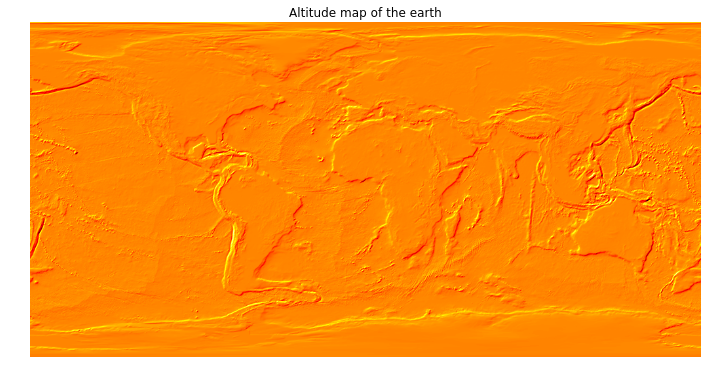

In [6]:
%%time

# step length
h = 3e4
# Calculating gradient
altitudeGrad = grad(altitudeData,h)
# Calculating intensity
altitudeIntensity = intensity(theta,phi,altitudeGrad)
# Displaying the result
plt.imshow(altitudeIntensity,cmap='hot')
plt.axis("off")
plt.title("Altitude map of the earth")

CPU times: user 1.34 s, sys: 3.33 ms, total: 1.34 s
Wall time: 1.33 s


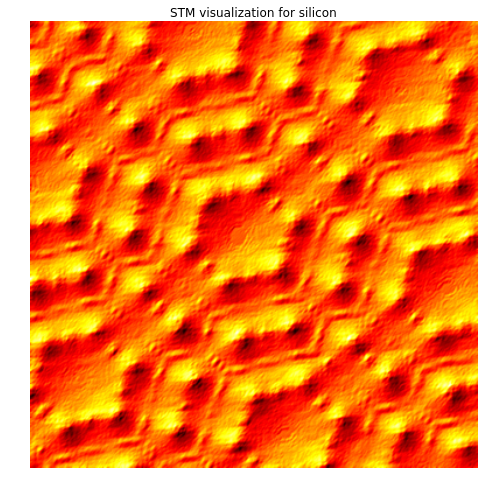

In [7]:
%%time

# Parameters:
h = 2.5
# Calculating gradient
stmGrad = grad(stmData,h)
# Calculating intensity
stmIntensity = intensity(theta,phi,stmGrad)
# Displaying the result
plt.title("STM visualization for silicon")
plt.axis("off")
plt.imshow(stmIntensity,cmap='hot')

## Secondo metodo: interpolazione bilineare

Un altro approccio al problema è la interpolazione dei campionamenti ed il calcolo della derivata della funzione interpolatrice. Un metodo di interpolazione per reticoli bidimensionali particolarmente semplice è la interpolazione bilineare, in questo caso la funzione interpolatrice ha la forma

\begin{equation}
f_\mathrm{bl}(x,y) = a x + b y + c x y + d
\end{equation}

Questo metodo di interpolazione si definisce bilineare nel senso che _fissata una variabile_ la dipendenza della funzione interpolatrice dalla seconda è lineare, benchè si osservi che quest'ultima è quadratica nelle due variabili. 

Inoltre si osserva che la funzione interpolatrice dipende da 4 parametri, dunque si avrà una funzione interpolatrice per ogni placchetta.

<img src="images/lattice.png"> 
<!--
In alternativa: 
from IPython.display import Image
Image("images/lattice.png") 
-->
<!-- 
Per calcolare i parametri è possibile interplolare linearmente i punti di una placchetta prima rispetto ad una variabile e successivamente rispetto all'altra (si può verificare direttamente che l'ordine delle due variabili non influisce sul risultato). 
-->

Siano $(x_1,y_1)$, $(x_1,y_2)$, $(x_2,y_1)$ e $(x_2,y_2)$ i vertici di una placchetta come in figura, allora, facendo uso della notazione $f_{ij} = f(x_i,y_j)$ e della osservazione sulla linearità rispetto ad una variabile fissata l'altra, si può scrivere

\begin{align}
f_\mathrm{bl}(x,y_1) & = f_{11} \frac{x-x_2}{x_1-x_2} - f_{21} \frac{x-x_1}{x_1-x_2} \\
f_\mathrm{bl}(x,y_2) & = f_{12} \frac{x-x_2}{x_1-x_2} - f_{22} \frac{x-x_1}{x_1-x_2} 
\end{align}

e pertanto 

\begin{align}
f_\mathrm{bl}(x,y) & = f_\mathrm{bl}(x,y_1) \frac{y-y_2}{y_1-y_2} - f_\mathrm{bl}(x,y_2) \frac{y-y_1}{y_1-y_2} \\
& = \left( f_{11} \frac{x-x_2}{x_1-x_2} - f_{21} \frac{x-x_1}{x_1-x_2} \right) \frac{y-y_2}{y_1-y_2} f_{12} - \left( \frac{x-x_2}{x_1-x_2} - f_{22} \frac{x-x_1}{x_1-x_2} \right) \frac{y-y_1}{y_1-y_2}
\end{align}

Ora è possibile calcolare la derivata della espressione precedente ed ottenere il risultato desiderato. Si pone pertanto il problema di scegliere un punto interno alla placchetta in cui calcolare la derivata. Se si seleziona il centro $(x_1 + \frac{h}{2},y_1 + \frac{h}{2})$ l'espressione si semplifica fortemente

\begin{align}
\frac{\partial f_\mathrm{bl}}{\partial x}(x_1 + \frac{h}{2},y_1 + \frac{h}{2}) & = \frac{1}{2 h} \left( f_{11} + f_{22} - f_{12} + f_{21} \right) \\
\frac{\partial f_\mathrm{bl}}{\partial y}(x_1 + \frac{h}{2},y_1 + \frac{h}{2}) & = \frac{1}{2 h} \left( f_{11} + f_{22} + f_{12} - f_{21} \right)
\end{align}

Si osserva che se le dimensioni della matrice di dati sono $(n_x,n_y)$ mentre le dimensioni della matrice gradiente calcolata in questo modo sono $(n_x-1,n_y-1)$, pertanto si ha una perdita di risoluzione trascurabile.

In [8]:
def grad2(pts,h):
    nx, ny = pts.shape
    grad = np.empty([nx-1,ny-1,3])
    
    ondiag = pts[1:,1:]-pts[:-1,:-1]
    offdiag = pts[:-1,1:]-pts[1:,:-1]
    
    grad[...,0] = (ondiag+offdiag)/h
    grad[...,1] = (ondiag-offdiag)/h
    grad[...,2] = 1.0

    return grad

Come si vede è possibile implementare questo metodo in maniera molto concisa utilizzando il broadcasting fra vettori. Inoltre non è necessario distinguere fra i bordi ed il centro della matrice di dati. Come mostrano gli esempi successivi questa implementazione, rispetto alla precedente, non richiede maggiori risorse di calcolo (almeno in termini di tempo di calcolo).

CPU times: user 4.65 s, sys: 33.3 ms, total: 4.68 s
Wall time: 4.64 s


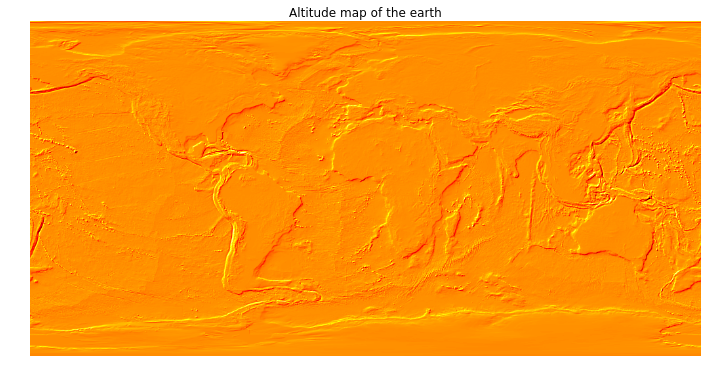

In [9]:
%%time

h = 3e4
# Calculating gradient
altitudeGrad2 = grad2(altitudeData,h)
# Calculating intensity
altitudeIntensity2 = intensity(theta,phi,altitudeGrad2)
# Displaying the result
plt.imshow(altitudeIntensity2,cmap='hot')
plt.axis("off")
plt.title("Altitude map of the earth")

CPU times: user 1.4 s, sys: 46.7 ms, total: 1.45 s
Wall time: 1.38 s


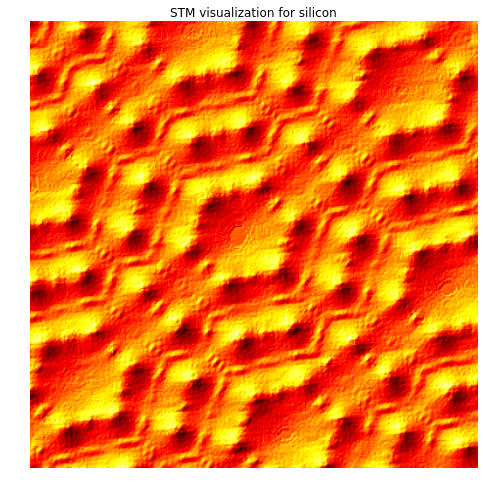

In [10]:
%%time

h = 2.5
# Calculating gradient
stmGrad2 = grad2(stmData,h)
# Calculating intensity
stmIntensity2 = intensity(theta,phi,stmGrad2)
# Displaying the result
plt.title("STM visualization for silicon")
plt.axis("off")
plt.imshow(stmIntensity2,cmap='hot')

Analogamente è possibile utilizzare metodi di interpolazione di ordine superiore ed algoritmi più complessi. Fra questi si menziona l'interpolazione bicubica, che è analoga alla spline cubica ma per reticoli bidimensionali.